In [1]:
include("../src/geqrf.jl")
using Random
rng = MersenneTwister(2018)
import LinearAlgebra.dot
import LinearAlgebra.norm
import LinearAlgebra.cond
import LinearAlgebra.triu
import LinearAlgebra.qr
import LinearAlgebra.UniformScaling
;

In [2]:
n = 4
x = rand(rng, n)

4-element Array{Float64,1}:
 0.6545394330653942
 0.10890604479083299
 0.7235855808911327
 0.7203666853246062

In [3]:
beta, v = house(x)

(0.4386315945756382, [1.872236706704729, 0.10890604479083299, 0.7235855808911327, 0.7203666853246062])

In [4]:
n = length(x)
y = zeros(n); y[1] = norm(x)
Px = x - beta * dot(v,x) * v
if Px[1] < 0
    Px = -Px
end
@show Px
@show y
@show norm(Px - y)

Px = [1.2176972736393348, -0.0, -0.0, -0.0]
y = [1.2176972736393348, 0.0, 0.0, 0.0]
norm(Px - y) = 0.0


0.0

In [5]:
n = 4
e1 = zeros(n); e1[1] = 1.0
e1'

1×4 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 1.0  0.0  0.0  0.0

In [6]:
# Insert Julia code for exercise here

In [7]:
# Testing QR factorization using Householder transformations
n = 4

# Building an orthogonal matrix Q
Q = zeros(n,n)
for j=0:n-1, i=0:n-1
    Q[i+1,j+1] = cos(π*(2i+1)*j/2n)
end
for j=1:n
    Q[:,j] /= norm(Q[:,j])
end

# Initializing an upper triangular matrix R
R = triu(Float64[ i/j for i=1:n, j=1:n ])

# Matrix A
A = Q*R

4×4 Array{Float64,2}:
 0.5   0.903281    1.10219    1.09724
 0.5   0.520598   -0.152935  -0.767982
 0.5  -0.0205981  -0.513732   0.267982
 0.5  -0.403281    0.231146  -0.0972388

In [8]:
# QR factorization
geqrf!(A)
# The factor R is stored in the upper triangular part of A

# These matrices should match up to the sign of each row
@show R,triu(A)

(R, triu(A)) = ([1.0 0.5 0.3333333333333333 0.25; 0.0 1.0 0.6666666666666666 0.5; 0.0 0.0 1.0 0.75; 0.0 0.0 0.0 1.0], [-1.0 -0.4999999999999999 -0.3333333333333335 -0.24999999999999956; 0.0 -0.9999999999999998 -0.6666666666666669 -0.4999999999999998; 0.0 0.0 1.0 0.75; 0.0 0.0 0.0 -1.0000000000000002])


([1.0 0.5 0.3333333333333333 0.25; 0.0 1.0 0.6666666666666666 0.5; 0.0 0.0 1.0 0.75; 0.0 0.0 0.0 1.0], [-1.0 -0.4999999999999999 -0.3333333333333335 -0.24999999999999956; 0.0 -0.9999999999999998 -0.6666666666666669 -0.4999999999999998; 0.0 0.0 1.0 0.75; 0.0 0.0 0.0 -1.0000000000000002])

In [9]:
# Illustrating the accuracy of QR factorizations using Householder transformations
n = 64

rng = MersenneTwister(2018)
Q, R = qr(rand(rng,n,n))
R = triu(rand(rng,n,n))

# Matrix A
A = Q*R

A0 = copy(A)
# Appending I as a way to get Q
A0 = hcat(A,UniformScaling(1.0))
# QR factorization
geqrf!(A0)
# The factor R is stored in the upper triangular part of A0
R0 = triu(A0[:,1:n])
# Q^T is stored in column n+1 to 2n
Q0 = A0[:,n+1:2*n]'

# Fixing the sign
for j=1:n
    if R0[j,j] * R[j,j] < 0
        R0[j,:] = -R0[j,:]
        Q0[:,j] = -Q0[:,j]
    end
end

condA = cond(A)
back_err = norm(Q0 * R0 - A)

# Accuracy of Q and R
@show norm(Q0' * Q0 - UniformScaling(1.0))   # Orthogonality
@show norm(R - R0)              # Forward error
@show back_err                  # Backward error
@show condA                     # Condition number of A
@show 1e-4 * condA * back_err   # Predicted forward error

norm(Q0' * Q0 - UniformScaling(1.0)) = 8.424823481338488e-15
norm(R - R0) = 8.827737710370503e-9
back_err = 2.3265521539450183e-14
condA = 5.453654900034587e9
0.0001 * condA * back_err = 1.268821255454827e-8


1.268821255454827e-8

In [10]:
# Systematic testing

n_test = 32:128
err = zeros(4,length(n_test))
k = 1

for n=n_test
    rng = MersenneTwister(2018 + n)
    Q, R = qr(rand(rng,n,n))
    R = triu(rand(rng,n,n))

    # Matrix A
    A = Q*R
    A0 = hcat(A,UniformScaling(1.0))
    
    # QR factorization
    geqrf!(A0)
    R0 = triu(A0[:,1:n])
    Q0 = A0[:,n+1:2*n]'

    # Fixing the sign
    for j=1:n
        if R0[j,j] * R[j,j] < 0
            R0[j,:] = -R0[j,:]
            Q0[:,j] = -Q0[:,j]
        end
    end

    condA = cond(A)
    back_err = norm(Q0 * R0 - A)

    # Saving values for plotting
    err[1,k] = norm(Q0' * Q0 - UniformScaling(1.0))   # Orthogonality
    err[2,k] = norm(R - R0)                           # Forward error
    err[3,k] = back_err                               # Backward error
    err[4,k] = 1e-4*condA*back_err                    # Predicted forward error
    k = k+1
end

In [11]:
using PlotlyJS

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-213768445739935102\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-13751882953576839240\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-213768445739935102\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

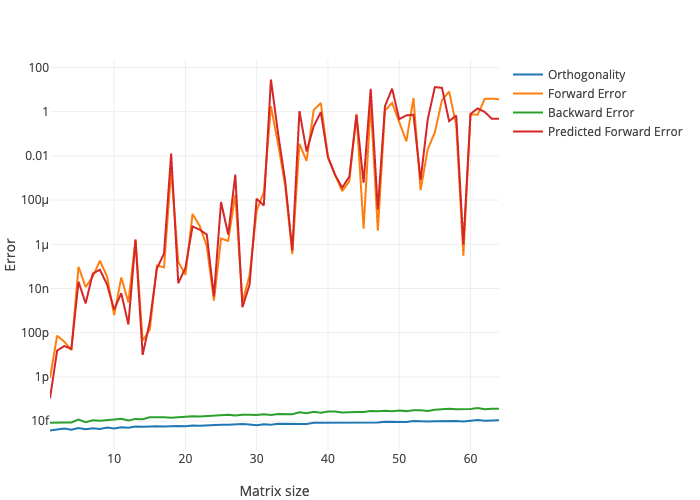

In [12]:
t1 = scatter(x=1:n, y=err[1,:], name="Orthogonality")
t2 = scatter(x=1:n, y=err[2,:], name="Forward Error")
t3 = scatter(x=1:n, y=err[3,:], name="Backward Error")
t4 = scatter(x=1:n, y=err[4,:], name="Predicted Forward Error")
l = Layout(yaxis_type="log", xaxis_title="Matrix size", yaxis_title="Error")
# l[:height] = 300
# l[:width] = 450
plot([t1, t2, t3, t4], l)